In [1]:
from time import time

import Levenshtein
import matplotlib.pyplot as plt
import torch
import torchinfo
from torchlake.ocr.datasets.trdg import SyntheticTextDataset
from torchlake.ocr.models.crnn import Crnn
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from tqdm import tqdm
from pathlib import Path

Missing modules for handwritten text generation.


In [2]:
artifacts_path = Path("../torchlake/ocr/artifacts")

# data

In [3]:
transform = v2.Compose([
    v2.Grayscale(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
])

In [4]:
dataset = SyntheticTextDataset("../torchlake/ocr/data/", transform)

In [5]:
num_labels = len(dataset.token_table)

## generate synthetic data

In [6]:
dataset.build_images(size=3)

d:\research\pytorch-implementations\.venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file d:\research\pytorch-implementations\.venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [6]:
# dataloader = DataLoader(dataset, batch_size=1)

# model

In [7]:
device = "cuda:0"

In [8]:
model = Crnn(1, 256, num_labels).to(device)

In [9]:
torchinfo.summary(model=model)

Layer (type:depth-idx)                   Param #
Crnn                                     --
├─Sequential: 1-1                        --
│    └─ConvBnRelu: 2-1                   --
│    │    └─Conv2d: 3-1                  640
│    │    └─ReLU: 3-2                    --
│    └─MaxPool2d: 2-2                    --
│    └─ConvBnRelu: 2-3                   --
│    │    └─Conv2d: 3-3                  73,856
│    │    └─ReLU: 3-4                    --
│    └─MaxPool2d: 2-4                    --
│    └─ConvBnRelu: 2-5                   --
│    │    └─Conv2d: 3-5                  295,168
│    │    └─ReLU: 3-6                    --
│    └─ConvBnRelu: 2-6                   --
│    │    └─Conv2d: 3-7                  590,080
│    │    └─ReLU: 3-8                    --
│    └─MaxPool2d: 2-7                    --
│    └─ConvBnRelu: 2-8                   --
│    │    └─Conv2d: 3-9                  1,179,648
│    │    └─BatchNorm2d: 3-10            1,024
│    │    └─ReLU: 3-11                   --
│ 

# training

In [10]:
criterion = nn.CTCLoss(blank=dataset.token_table[dataset.ignored], reduction="sum")
optim = torch.optim.Adadelta(model.parameters())

In [11]:
epoch = 20
batch_size = 64

In [24]:
training_loss = []
for e in range(epoch):
    running_loss = 0

    optim.zero_grad()
    acc_iter = 0
    for data in tqdm(dataset):
        acc_iter += 1
        img, label = data
        img = img.unsqueeze(0).to(device)

        output = model(img).log_softmax(2)
        pred_len = torch.Tensor([len(output)]).long().to(device)
        target_len = torch.Tensor([len(label)]).long().to(device)
        loss = criterion(output, label, pred_len, target_len)
        loss /= batch_size

        loss.backward()

        if acc_iter % batch_size == 0:
            optim.step()
            optim.zero_grad()

        running_loss += loss.item()

    print(f"epoch {e+1}: ", running_loss / len(dataset))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 41.89it/s]


epoch 1:  4.4818968277156745


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 42.47it/s]


epoch 2:  3.279418440458562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:22<00:00, 40.84it/s]


epoch 3:  3.164849543526022


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:22<00:00, 41.41it/s]


epoch 4:  3.0185444700107595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 41.94it/s]


epoch 5:  2.8743021878411827


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 41.83it/s]


epoch 6:  2.7686706089895536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:22<00:00, 41.68it/s]


epoch 7:  2.651824342139666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:22<00:00, 41.53it/s]


epoch 8:  2.4456455729625843


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 41.98it/s]


epoch 9:  2.4144177270286225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:22<00:00, 40.97it/s]


epoch 10:  2.293258195609049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:22<00:00, 39.92it/s]


epoch 11:  2.1303256221748645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 42.03it/s]


epoch 12:  1.8527025518236857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 42.49it/s]


epoch 13:  1.6088248062107817


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 43.00it/s]


epoch 14:  1.3132445810845605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 42.35it/s]


epoch 15:  1.1280629299824534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 42.55it/s]


epoch 16:  1.1299146820054529


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 42.85it/s]


epoch 17:  0.7546089798078136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 42.64it/s]


epoch 18:  0.7489976978014692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 42.17it/s]


epoch 19:  0.551282675758264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:21<00:00, 41.90it/s]

epoch 20:  0.5692796352986969


In [25]:
torch.save(model, artifacts_path.joinpath("models/crnn/ocr.pth").as_posix())

In [ ]:
model = torch.load(artifacts_path.joinpath("models/crnn/ocr.pth").as_posix())

# predict

In [26]:
def tensor2str(values: torch.Tensor, itos_table: dict) -> str:
    return "".join([itos_table.get(value.item()) for value in values])

In [27]:
def decode(
    output: torch.Tensor,
    itos_table: dict,
    remove_blank: bool = False,
    remove_repeat: bool = False,
) -> str:
    pred_text = tensor2str(output, itos_table)
    pred_text = pred_text.strip()

    if remove_repeat:
        placeholder = ""
        for i, d in enumerate(pred_text):
            if i == len(pred_text) - 1:
                placeholder += d
                break
            if d != pred_text[i + 1]:
                placeholder += d
        pred_text = placeholder

    if remove_blank:
        pred_text = pred_text.replace("😀", "")

    return pred_text

In [28]:
lookup_back = {v: k for k, v in dataset.label_table.items()}

In [29]:
model.eval()
with torch.no_grad():
    a = time()
    for i, (img, label) in enumerate(dataset):
        output = model(img.unsqueeze(0).to(device))[:, 0, :].max(1)[1]
        print(i + 1)
        print("prediction:")
        print(decode(output, lookup_back, remove_blank=True, remove_repeat=True))
        print("label:")
        print(tensor2str(label, lookup_back))
        print("------------------------------------------------")

        if i > 10:
            break
    b = time()
    print("seconds for 100 examples: ", b - a)

1
prediction:
1r 4 24 o7 4 Voltry Yotterr Vvtoyr corcio tvor frcies seyverol wroy ects celoryet os Yisr corscirys terciers trrit trey ex wxsvre Tre Cro tote Citserver 1Yorry4 29 2049 Yetrtevet Cecerive s 2047 4 vo Vevs14
label:
'In A Bit of a Holding Pattern Uptown condo boom fades Several projects delayed as risk conscious lenders limit their exposure The Charlotte Observer March 20 2008 Retrieved December 5 2017 via NewsLi
------------------------------------------------
2
prediction:
Wensneetf Trump Shon Mirers Realrty Paln Beaeh Daity Nens Pebruary 28 2004 Retrteved Novenber 15 2017 The latest tak is dubbed ice Cscapades as the contestants oompete in the mnatetplace debutof 7
label:
'Newsweek' Trump Show Mirrors Reality Palm Beach Daily News February 26 2004 Retrieved November 15 2017 The latest task is dubbed Ice Escapades as the contestants compete in the marketplace debut of T
------------------------------------------------
3
prediction:
Truyry Force Cre' tre ulore trot cories 

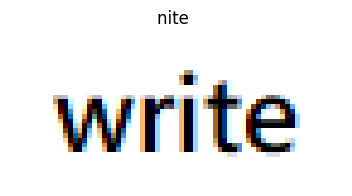

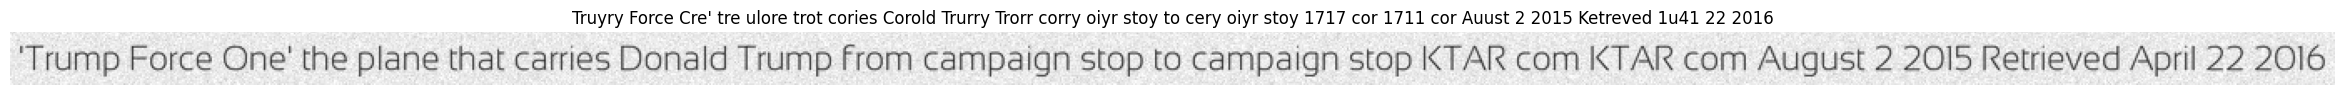

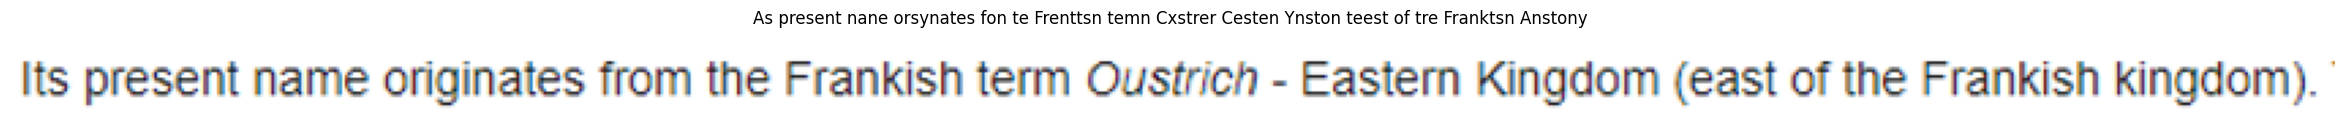

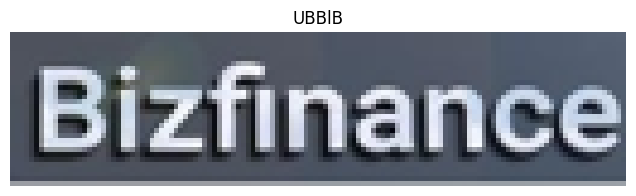

In [30]:
demo_list = [
    ("mspaint", artifacts_path / "write.png"),
    (
        "synthetic",
        artifacts_path / """../data/'Trump Force One' the plane that carries Donald Trump from campaign stop to campaign stop KTAR com KTAR com August 2 2015 Retrieved April 22 2016.png""",
    ),
    ("wiki", artifacts_path / "wiki.png"),
    ("internet", artifacts_path / "signboard.jpg"),
]

# plt.figure(figsize=(30,8))
for i, (source, name) in enumerate(demo_list):
    demo_pic = Image.open(name)
    w, h = demo_pic.size
    demo_pic = demo_pic.resize((int(w * 32 / h), 32))
    demo_text = transform(demo_pic).unsqueeze(0).to(device)
    decoded = decode(
        model(demo_text)[:, 0, :].max(1)[1],
        lookup_back,
        remove_blank=True,
        remove_repeat=True,
    )

    plt.figure(figsize=(30, 2))
    plt.title(decoded)
    plt.axis("off")
    plt.imshow(demo_pic)
    # print(decoded)

# evaluation

In [31]:
score = 0

for img, label in tqdm(dataset):
    output = model(img.unsqueeze(0).to(device))[:, 0, :].max(1)[1]
    dist = Levenshtein.distance(
        decode(output, lookup_back, remove_blank=True, remove_repeat=True),
        tensor2str(label, lookup_back),
    )
    score += dist

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:25<00:00, 36.59it/s]


In [32]:
score / len(dataset)

21.18300653594771